In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import logging
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt


import pudl

from pudl.analysis.allocate_net_gen import *
from pudl.analysis.allocate_net_gen import _test_gen_pm_fuel_output, _test_gen_fuel_allocation

mpl.style.use('dark_background')
pd.options.display.max_columns = None
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Implementation Zone for Allocating Fuel

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
# the fill_net_gen arg is employing a beta feature!
# It will result in a much higher coverage of net generation
# and fuel consuption, but it has known issues with multi-fuel plants.
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine,
    freq='AS',
    fill_fuel_cost=True,
    roll_fuel_cost=True,
    fill_net_gen=False,
)

In [5]:
# current generator-level output
net_gen_fuel_alloc = pudl_out.gen_fuel_by_generator_eia923(update=True)

Replaced 0.7% MSN and MSB energy_source_codes w/ MSW
Filling technology type
Replaced 4.0% MSN and MSB energy_source_codes w/ MSW
Removing 4315 generators that retired mid-year out of 491469
Ratio calc types: 
   All gens w/in generation table:  77404#, 1.3e+07 MW
   Some gens w/in generation table: 2666#, 1.6e+05 MW
   No gens w/in generation table:   442436#, 2.1e+07 MW
1.214% of records have are partially off from their 'IDX_PM_ESC' group
gen v fuel table net gen diff:      36.6%
new v fuel table net gen diff:      94.9%
8.30% of generator records are more that 5% off from the net generation table
Yay you passed the test for the `frac_cap` column for the not_in_bf records..
Wahoo! You passed the test for fuel allocation for the not_in_bf records.
You've passed the frac_cap test for the `in_bf_tbl` records
105.82%of the fuel from the gf table has been allocated to records not in the bf table
98.61% of the fuel from the bf table has been allocated
103.37% of the fuel from the gf table

## Common Inputs Between Net Gen and Fuel Allocation

In [6]:
# extract all of the tables from pudl_out early in the process and select
# only the columns we need. this is for speed and clarity.
gf = (
    pudl_out.gf_eia923()
    .loc[:, IDX_PM_ESC + ["net_generation_mwh", "fuel_consumed_mmbtu"]]
    .pipe(group_msw_codes, IDX_PM_ESC)
)
gen = (
    pudl_out.gen_original_eia923().loc[:, IDX_GENS + ["net_generation_mwh"]]
    # removes 4 records with NaN generator_id as of pudl v0.5
    .dropna(subset=IDX_GENS)
)
gens = pudl_out.gens_eia860().loc[
    :,
    IDX_GENS
    + [
        "prime_mover_code",
        "unit_id_pudl",
        "capacity_mw",
        "fuel_type_count",
        "operational_status",
        "retirement_date",
    ]
    + list(pudl_out.gens_eia860().filter(like="energy_source_code")),
]
bf = (
    pudl_out.bf_eia923()
    .loc[:, IDX_U_ESC + ["fuel_consumed_mmbtu"]]
    .pipe(remove_bf_nulls)
    .pipe(group_msw_codes, IDX_U_ESC)
)

# do the association!
gen_assoc = associate_generator_tables(gf=gf, gen=gen, gens=gens, bf=bf)

# Generate a fraction to use to allocate net generation by.
# These two methods create a column called `frac`, which will be a fraction
# to allocate net generation from the gf table for each `IDX_PM_ESC` group
gen_pm_fuel = prep_alloction_fraction(gen_assoc)

Replaced 0.7% MSN and MSB energy_source_codes w/ MSW
Replaced 4.0% MSN and MSB energy_source_codes w/ MSW
Removing 4315 generators that retired mid-year out of 491469


## Fuel Allocation

In [7]:
fuel_alloc = allocate_fuel_by_gen_esc(
        gen_pm_fuel, gf=gf, bf=bf, drop_interim_cols=False
    )

Yay you passed the test for the `frac_cap` column for the not_in_bf records..
Wahoo! You passed the test for fuel allocation for the not_in_bf records.
You've passed the frac_cap test for the `in_bf_tbl` records
105.82%of the fuel from the gf table has been allocated to records not in the bf table
98.61% of the fuel from the bf table has been allocated
103.37% of the fuel from the gf table has been allocated


## Explore Issues

In [8]:
IDX_PLANT = ['plant_id_eia', 'report_date']

plant_test = (
    pd.merge(
        fuel_alloc.groupby(IDX_PLANT)[['fuel_consumed_mmbtu']].sum(min_count=1),
        gf.groupby(IDX_PLANT)[['fuel_consumed_mmbtu']].sum(min_count=1),
        right_index=True, left_index=True,
        suffixes=('', '_gf_test'),
        validate='1:1'
    )
    .merge(
        bf.groupby(IDX_PLANT)[['fuel_consumed_mmbtu']].sum(min_count=1),
        right_index=True, left_index=True,
        suffixes=('', '_bf_test'),
        validate='1:1'
    )
    .assign(
        diffs_gf=lambda x: x.fuel_consumed_mmbtu - x.fuel_consumed_mmbtu_gf_test,
        perc_gf=lambda x: x.diffs_gf / x.fuel_consumed_mmbtu_gf_test,
        diffs_bf=lambda x: x.fuel_consumed_mmbtu - x.fuel_consumed_mmbtu_bf_test,
        perc_bf=lambda x: x.diffs_bf / x.fuel_consumed_mmbtu_bf_test,
    )
)

In [9]:
plant_test.describe().T

,count,mean,std,min,25%,50%,75%,max
fuel_consumed_mmbtu,16319.0,2.185462e+07,3.499794e+07,0.000000e+00,2.495417e+06,8835637.966,2.593636e+07,6.750110e+08
fuel_consumed_mmbtu_gf_test,16333.0,1.994959e+07,2.946707e+07,0.000000e+00,2.479861e+06,8482417.000,2.434841e+07,2.518821e+08
fuel_consumed_mmbtu_bf_test,15647.0,1.814696e+07,2.926968e+07,1.006000e+00,1.682490e+06,6248828.181,2.096006e+07,2.518837e+08
diffs_gf,16319.0,1.891710e+06,1.551865e+07,-1.572689e+08,-3.706500e+00,0.000,1.645565e+04,5.062582e+08
perc_gf,16290.0,1.173282e-01,4.275184e-01,-1.000000e+00,-2.049350e-06,0.000,3.442312e-03,7.834299e+00
diffs_bf,15634.0,3.700120e+06,1.715534e+07,-1.572687e+08,0.000000e+00,0.000,2.070012e+05,6.395701e+08
perc_bf,15634.0,1.850918e+03,1.203970e+05,-1.000000e+00,0.000000e+00,0.000,7.299244e-02,1.069511e+07


In [10]:
baddies = plant_test[
    (abs(plant_test.perc_gf) != np.inf)
    & ~np.isclose(plant_test.perc_gf, 0)
    & (plant_test.perc_gf.notnull())
    & ~np.isclose(plant_test.perc_bf, 0)
]
# much too many baddies
print(len(baddies), len(plant_test))

8286 16333


In [11]:
# baddies.sort_values(by=['perc_gf'])

In [12]:
# ex: GF & BF fuel records that don't match with gen's fuel types
# need to implement a solution for non-associated GF & BF records
# plant_id_eia = 3946
# year = 2011

# ex: PM code is missing for one gen
# plant_id_eia = 10030
# year = 2013

In [14]:
plant_id_eia = 10030
year = 2013

fuel_alloc[
    (fuel_alloc.plant_id_eia == plant_id_eia)
    & (fuel_alloc.report_date.dt.year == year)
].set_index(IDX_PM_ESC + ['generator_id', 'unit_id_pudl']).filter(like='fuel_con')

fuel_consumed_mmbtu_gf_tbl  fuel_consumed_mmbtu_bf_tbl  fuel_consumed_mmbtu_gf_tbl_fuel  fuel_consumed_mmbtu  fuel_consumed_mmbtu_not_in_bf  fuel_consumed_mmbtu_gf_tbl_test
report_date plant_id_eia energy_source_code prime_mover_code generator_id unit_id_pudl                                                                                                                                                                              
2013-01-01  10030        DFO                GT               KD-2         NaN                               2696.0                         NaN                           2696.0          2696.000000                         2696.0                           2696.0
                         NG                 NaN              COG1         1                                    NaN                    787179.5                         906260.0        208371.044118                            NaN                              NaN
                                            CT               KD-1         1                               731028.0                    787179.5                         906260.0        578808.455882                            NaN                              NaN
                                            GT               KD-2         NaN                             119077.0                         NaN                         906260.0        906260.000000                       906260.0                         906260.0

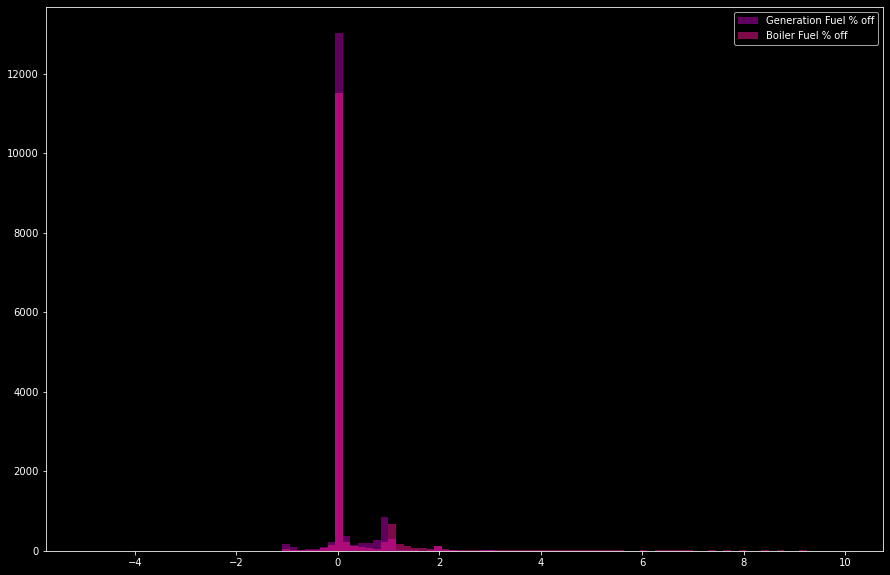

In [15]:

plt.hist(
    plant_test[
        (abs(plant_test.perc_gf) != np.inf)
        #& ~np.isclose(plant_test.perc_gf, 0)
    ].perc_gf,
    bins=100,
    range=(-5,10),
    alpha=.75,
    color='purple',
    label='Generation Fuel % off'
    
)

plt.hist(
    plant_test[
        (abs(plant_test.perc_bf) != np.inf)
       # & ~np.isclose(plant_test.perc_bf, 0)
    ].perc_bf,
    bins=100,
    range=(-5,10),
    alpha=.5,
    color='deeppink',
    label='Boiler Fuel % off'
)

plt.legend()
plt.title("")
plt.show()

# Examples! (future unit tests)

In [16]:
#IDX_PM_FUEL= ['prime_mover_code', 'fuel_type'] # plus 'plant_id_eia', 'report_date' of course
# inputs
gens_ex = pd.DataFrame({
    'generator_id': ['A', 'B', 'C', 'D'],
    'unit_id_pudl': [1, 1, 2, 3],
    'prime_mover_code': ['GT', 'ST', 'GT', 'GT'],
    'energy_source_code_1': ['NG', 'NG', 'NG', 'NG'],
    'energy_source_code_2': ['DFO', np.nan, 'DFO', np.nan],
    'capacity_mw': [100, 50, 25, 10]
})
bf_ex = pd.DataFrame({
    'boiler_id': ['X1', 'Y1'],
    'fuel_type': ['NG', 'DFO'],
    'unit_id_pudl': [1, 1],
    'fuel_consumed_mmbtu': [8, 2]
})
gf_ex = pd.DataFrame({
    'prime_mover_code': 
        ['GT', 'ST', 'GT'],
    'fuel_type': 
        ['NG', 'NG', 'DFO'],
    'fuel_consumed_mmbtu': 
        [7, 2, 3]
})

## Interim Output
# stack the gens table with the different fuel types
gens_stacked_ex = pd.DataFrame({
    'generator_id': ['A', 'A', 'B', 'C', 'C', 'D'],
    'unit_id_pudl': [1, 1, 1, 2, 2, 3],
    'prime_mover_code': ['GT', 'GT', 'ST', 'GT', 'GT', 'GT'],
    'fuel_type': ['NG', 'DFO', 'NG', 'NG', 'DFO', 'NG']
})
# associate the generators w/ the gf table (mergeon IDX_PM_F)
# and calculate values (sums/groupbys)
gen_assoc_ex = pd.DataFrame({
    'generator_id': ['A', 'A', 'B', 'C', 'C', 'D'],
    'unit_id_pudl': [1, 1, 1, 2, 2, 3,],
    'prime_mover_code': 
        ['GT', 'GT',  'ST', 'GT', 'GT', 'GT'],
    'fuel_type': 
        ['NG', 'DFO', 'NG', 'NG', 'DFO', 'NG'],
    'capacity_mw': 
        [100,  100,   50,   25,   25,    10],
    # what we are trying to allocate
    # merge btwn gen_assoc & gf, by PM_F
    # Fuel totals on a per-pm-fuel basis
    'fuel_consumed_mmbtu_gf_tbl': 
        [7, 3, 2, 7, 3, 7],

    ########
    # sums/groupbys that we need before doing any of the assign-type calcs
    'capacity_mw_pm_fuel': 
        [135,  125,   50,   135,  125,   10],
    # (summed by PM)
    'fuel_consumed_mmbtu_gf_tbl_pm':
        [10, 10, 2, 10, 10, 10],
    # from gf table, summed by fuel
    'fuel_consumed_mmbtu_gf_tbl_fuel': 
        [9, 3, 9, 9, 3, 9],
    # reported by unit and fuel type in BF
    # merged into association table, broadcasting across prime mover
    'fuel_consumed_mmbtu_bf_tbl':
        [8, 2, 8, np.nan, np.nan, np.nan],
    'in_bf_tbl':
        [True, True, True, False, False, False],
    # sum of cap in [pm, fuel + exist_in_bf] group
    'capacity_mw_pm_fuel_in_bf_tbl_group':
        [100, 100, 50, 35, 35, 35],
})

In [17]:
#  gen_assoc tabl but only the records that don't exist in bf
# plus the calculated fields we need to generate the final fuel
not_in_bf_tbl = pd.DataFrame({
    ### columns from gen_assoc
    'generator_id': ['C', 'C', 'D'],
    'unit_id_pudl': [2, 2, 3,],
    'prime_mover_code': ['GT', 'GT', 'GT'],
    'fuel_type': ['NG', 'DFO', 'NG'],
    'capacity_mw': [25, 25, 10],
    # what we are trying to allocate
    # merge btwn gen_assoc & gf, by PM_F
    # Fuel totals on a per-pm-fuel basis
    'fuel_consumed_mmbtu_gf': 
        [7, 3, 7],
    
    ########
    # sums/groupbys that we need before doing any of the assign-type calcs
    # from bf table, summed by fuel
    'fuel_consumed_mmbtu_bf_fuel':
        [8, 2, 8],
    # from gf table, summed by fuel
    'fuel_consumed_mmbtu_gf_fuel': 
        [9, 3, 9],
    # sum of cap in [pm, fuel + exist_in_bf] group
    # total capacity in each pm fuel group
    'capacity_mw_pm_fuel_in_bf_tbl_group':
        [35, 25, 35],
    
    # what fuel should be assigned to these "not in bf" 
    # records based on fuel groupings?
    # fuel that should be allocated to the not-reporting-to-bf records
    # (the fuel in the gf tbl's fuel group - the fuel in the bf tbl's fuel group)
    # (fuel_consumed_mmbtu_gf_fuel - fuel_consumed_mmbtu_bf_fuel) / fuel_consumed_mmbtu_gf
    'fuel_consumed_mmbtu_not_in_bf': 
        [(9-8), (3-2), (9-8)],
    
    ### Get the frac_cap (used for allocating within gens that don't report to bf)
    # Portion of capacity for each PM_FUEL group
    # capacity_mw / capacity_mw_pm_fuel_in_bf_tbl_group
    'frac_cap':
        [25/35, 25/25, 10/35],
    
    # frac * fuel_consumed_mmbtu_gf
    'fuel_consumed_mmbtu':
        [(9-8) * (25/35), (3-2) * (35/35), (9-8) * (10/35)],
})

# aggregate the generator allocation to the units
not_in_bf_unit = pd.DataFrame({
    'unit_id_pudl': 
        [2, 3],
    'fuel_consumed_mmbtu':
        [1.71, 0.028]
})

# aggregate the bf table to the unit leve
bf_unit = pd.DataFrame({
    'unit_id_pudl': [1],
    'fuel_consumed_mmbtu': [10]
})

all_unit = pd.DataFrame({
    'unit_id_pudl': 
        [1, 2, 3],
    'fuel_consumed_mmbtu':
        [10, 1.714, 0.286]
})

In [18]:
assert(all_unit.fuel_consumed_mmbtu.sum() == gf_ex.fuel_consumed_mmbtu.sum())

### Allocating the boiler fuel data to generators
We don't need to do this if our end goal is to aggregate to the unit level... but it may be helpful for other contexts so I'm leaving this here for now. This exploration is not complete, but it was an attempt to allocate the boiler-fuel data to the generator level.

In [19]:
# beginning of unit
frac_df_in_bf = pd.DataFrame({
    'generator_id': ['A', 'A', 'B'],
    'unit_id_pudl': [1, 1, 1],
    'prime_mover_code': ['GT', 'GT', 'ST'],
    'fuel_type': ['NG', 'DFO', 'NG'],
    'capacity_mw': 
        [100, 100, 50],
    # reported by unit and fuel type in BF
    # merged into association table, broadcasting across prime mover
    'fuel_consumed_mmbtu_bf':
        [8, 2, 8],

    ########
    # we are going to equally allocate fuel burned within a unit
    # to the various generators (regardless of their prime mover)
    # based on capacity
    # sums/groupbys that we need before doing any of the assign-type calcs
    'capacity_mw_fuel_in_bf_tbl': 
        [150, 100, 150],
    # capacity_mw /capacity_mw_fuel_in_bf_tbl
    'frac_cap':
        [100/150, 100/100, 50/150],
    # fuel_consumed_mmbtu_bf * frac_cap
    'fuel_consumed_mmbtu':
        [8*(100/150), 2*(100/100), 8*(50/150)],
})

assert(frac_df_in_bf.fuel_consumed_mmbtu.sum() == bf_ex.fuel_consumed_mmbtu.sum())

# Explore Problem

In [20]:
fuel_diff_val = bf.fuel_consumed_mmbtu.sum() / gf.fuel_consumed_mmbtu.sum()
logger.info(f"{fuel_diff_val:.02%} fuel consumption missing from gen table")

33.99% fuel consumption missing from gen table


In [21]:
idx_cols_plant = ['plant_id_eia','report_date']
fuel_diff = (
    pd.merge(
        bf.groupby(by=idx_cols_plant)[['fuel_consumed_mmbtu']].sum(),
        gf.groupby(by=idx_cols_plant)[['fuel_consumed_mmbtu']].sum(),
        right_index=True,
        left_index=True,
        suffixes=('_bf','_gf'),
        how='outer'
    )
    .assign(
        fuel_diff_num=lambda x: x.fuel_consumed_mmbtu_gf.fillna(0) - x.fuel_consumed_mmbtu_bf.fillna(0),
        fuel_diff_rate=lambda x: x.fuel_consumed_mmbtu_bf.fillna(0)/ x.fuel_consumed_mmbtu_gf.fillna(0)
    )
    .merge(
        gens.groupby(by=idx_cols_plant)
        [['generator_id','prime_mover_code']]
        .nunique()
        .add_suffix('_count'),
        right_index=True,
        left_index=True,
        how='outer'
    )
    .reset_index()
)

diff_mask = (fuel_diff.fuel_diff_num.notnull()
    & (fuel_diff.fuel_diff_num != 0)
    & (~np.isclose(abs(fuel_diff.fuel_diff_rate), 1))
    & (~np.isclose(abs(fuel_diff.fuel_diff_rate), 0)))

logger.info(len(fuel_diff[fuel_diff.fuel_diff_num < 0]))
logger.info(len(fuel_diff[fuel_diff.fuel_diff_num >= 0]))
logger.info(len(fuel_diff[fuel_diff.fuel_diff_num.isnull()]))

diff_w_many_pms = fuel_diff[(fuel_diff.prime_mover_code_count > 1) & diff_mask]
diff_w_one_pm = fuel_diff[(fuel_diff.prime_mover_code_count == 1) & diff_mask]
logger.info(
    f"{len(diff_w_many_pms)/len(fuel_diff[diff_mask]):.02%} of records w/ gen v gen_fuel diff that have >1 prime mover")


4529
126832
38500
88.21% of records w/ gen v gen_fuel diff that have >1 prime mover


In [22]:
logger.info(
    f"{len(fuel_diff[fuel_diff.fuel_diff_rate > 1.00001])/len(fuel_diff):.02%} of records that have more net gen in net gen table"
)

0.13% of records that have more net gen in net gen table


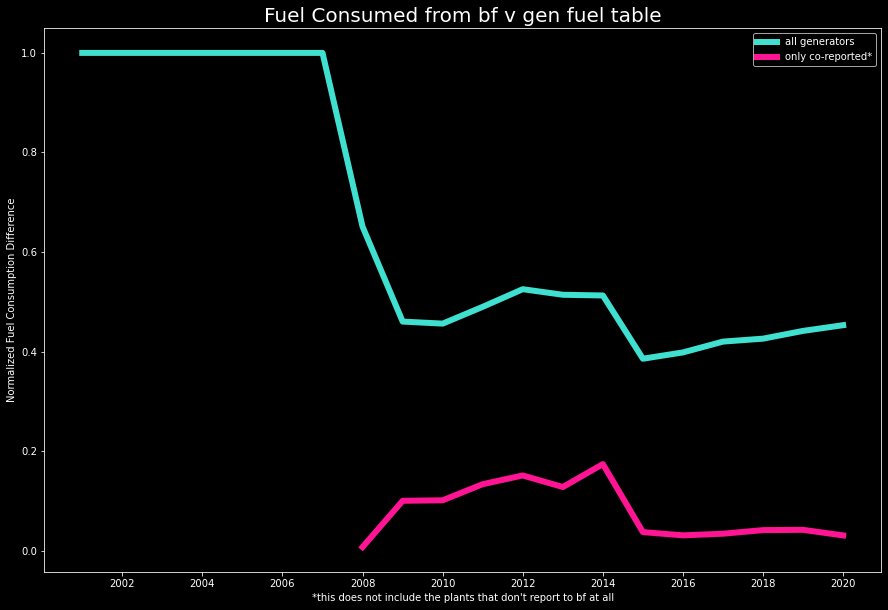

In [23]:
plt.plot((fuel_diff.groupby(by='report_date',dropna=False).sum().fuel_diff_num
          /fuel_diff.groupby(by='report_date',dropna=False).sum().fuel_consumed_mmbtu_gf),
         label='all generators', linewidth=6, color='turquoise'
        )
plt.plot((fuel_diff[(fuel_diff.fuel_consumed_mmbtu_bf.notnull())]
          .groupby(by='report_date',dropna=False).sum().fuel_diff_num
          /fuel_diff.groupby(by='report_date',dropna=False).sum().fuel_consumed_mmbtu_gf
         ),
         label='only co-reported*', linewidth=6, color='deeppink'
        )

plt.legend()
plt.ylabel("Normalized Fuel Consumption Difference")
plt.xlabel("*this does not include the plants that don't report to bf at all")
plt.title("Fuel Consumed from bf v gen fuel table", size=20)
plt.show()

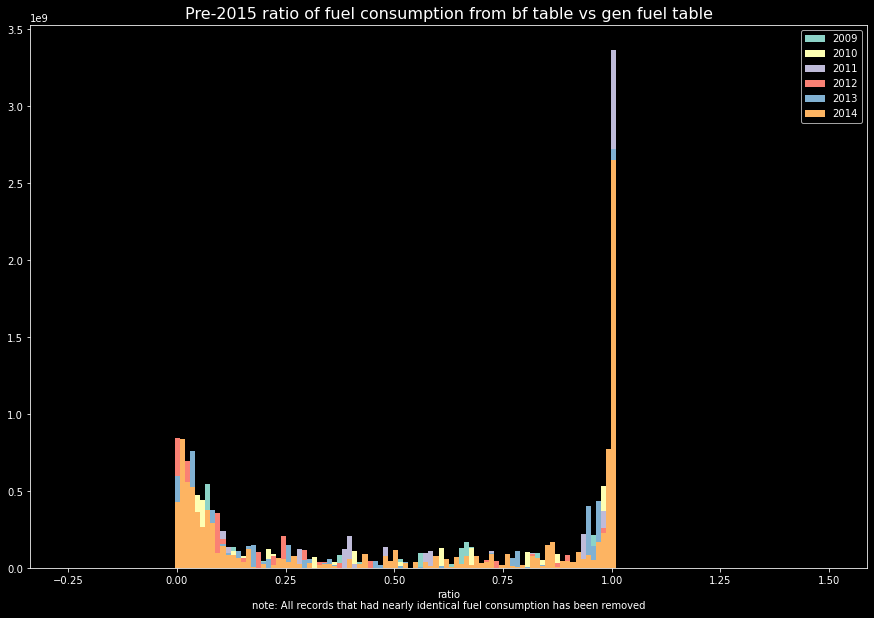

In [24]:
for year in range(2009,2015):
    df = fuel_diff[diff_mask & (fuel_diff.report_date.dt.year == year)]
    plt.hist(
        df.fuel_diff_rate,
        bins=150,
        range=(-.25,1.5),
        label=year,
        weights=abs(df.fuel_consumed_mmbtu_gf)
    )
plt.title("Pre-2015 ratio of fuel consumption from bf table vs gen fuel table", size=16)
plt.legend()
plt.xlabel("""ratio
note: All records that had nearly identical fuel consumption has been removed""")
plt.show()

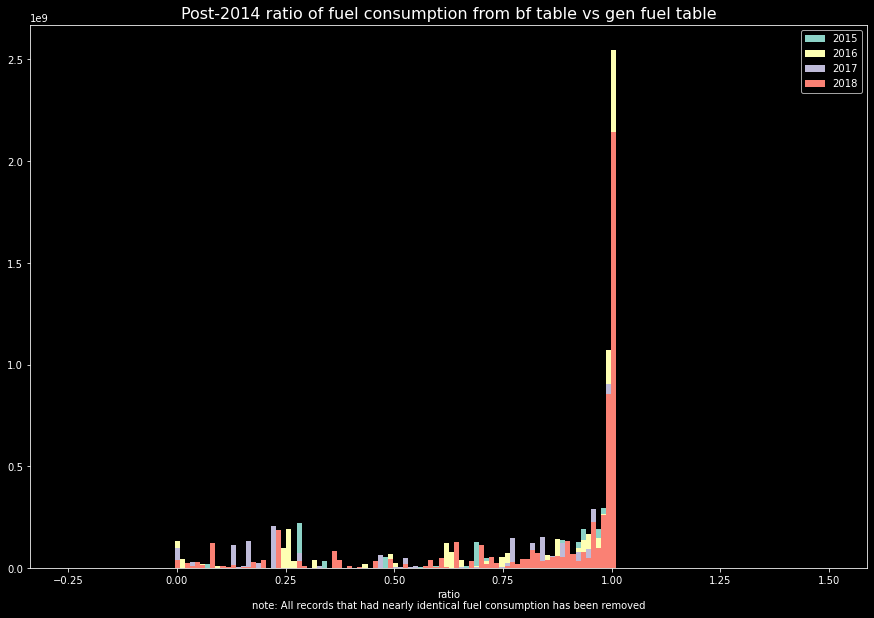

In [25]:
for year in range(2015,2019):
    df = fuel_diff[diff_mask & (fuel_diff.report_date.dt.year == year)]
    plt.hist(
        df.fuel_diff_rate,
        bins=150,
        range=(-.25,1.5),
        label=year,
        weights=abs(df.fuel_consumed_mmbtu_gf)
    )
plt.title("Post-2014 ratio of fuel consumption from bf table vs gen fuel table", size=16)
plt.legend()
plt.xlabel("""ratio
note: All records that had nearly identical fuel consumption has been removed""")
plt.show()